# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
import random

import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
SEED = 7
random.seed(SEED)
numpy.random.seed(SEED)

In [3]:
def read_data(path="boston.csv"):
    dataframe = numpy.genfromtxt(path, delimiter=",", skip_header=15)
    numpy.random.seed(42)
    numpy.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [4]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = numpy.random.randn(size, dim)
    w = numpy.random.randn(dim + 1)
    noise = noise * numpy.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [5]:
def mse(y_true: numpy.ndarray, y_predicted: numpy.ndarray):
    diff = y_true - y_predicted
    return (diff * diff).mean()

def r2(y_true: numpy.ndarray, y_predicted: numpy.ndarray):
    diff = y_true - y_predicted
    u = (diff * diff).sum()
    var = y_true - y_true.mean()
    v = (var * var).sum()
    return 1 - u / v

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [6]:
def add_ones_feature(x: numpy.ndarray) -> numpy.ndarray:
    new_x = numpy.ones((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, :-1] = x
    return new_x

In [7]:
class NormalLR:
    _x: numpy.ndarray = None
    _y: numpy.ndarray = None
    _w: numpy.ndarray = None
    def __init__(self):
        pass
    
    def fit(self, x: numpy.ndarray, y: numpy.ndarray):
        self._x = add_ones_feature(x)
        self._y = y.copy()
        x_t = self._x.T
        self._w = numpy.linalg.inv(x_t @ self._x) @ x_t @ self._y

    def predict(self, x: numpy.ndarray) -> numpy.ndarray:
        if self._w is None:
            raise RuntimeError("fit regression before making predictions")
        return add_ones_feature(x) @ self._w

In [8]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [9]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009874813186107334, R2: 0.9984125396879902


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с learning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [10]:
class GradientLR:
    _x: numpy.ndarray = None
    _y: numpy.ndarray = None
    _w: numpy.ndarray = None
    def __init__(self, alpha: float, iterations: int = 10000, l: float = 0., tol: float = 1e-8):
        self._alpha = alpha
        self._iterations = iterations
        self._l = l
        self._tol = tol
    
    def fit(self, x: numpy.ndarray, y: numpy.ndarray):
        self._x = add_ones_feature(x)
        self._y = y.copy()
        x_t = self._x.T
        self._w = numpy.zeros(self._x.shape[1])
        for i in range(self._iterations):
            grad = 2 / x.shape[0] * x_t @ (self._x @ self._w - self._y) +\
                   self._l * numpy.sign(self._w)
            if numpy.alltrue(grad < self._tol):
                break
            self._w -= self._alpha * grad

    def predict(self, x: numpy.ndarray):
        if self._w is None:
            raise RuntimeError("fit regression before making predictions")
        return add_ones_feature(x) @ self._w

In [11]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = numpy.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [12]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

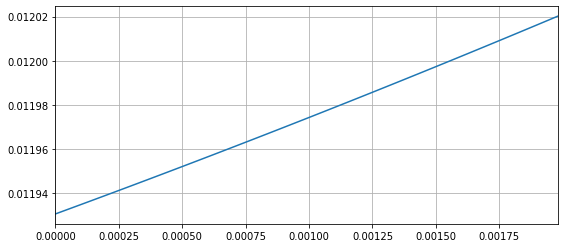

In [13]:
build_plot(X_train, y_train, X_val, y_val)

In [14]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009077597377692256, R2: 0.9942878191148885


### Задание 4 (2 балла)
Протестируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации.

In [15]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [16]:
scaler_feature = StandardScaler()
X_train = scaler_feature.fit_transform(X_train)
X_val = scaler_feature.transform(X_val)

# scaler_target = StandardScaler()
# y_train = scaler_target.fit_transform(y_train.reshape(-1, 1)).ravel()
# y_val = scaler_target.transform(y_val.reshape(-1, 1)).ravel()

In [17]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.080836914, R2: 0.6872797475661049


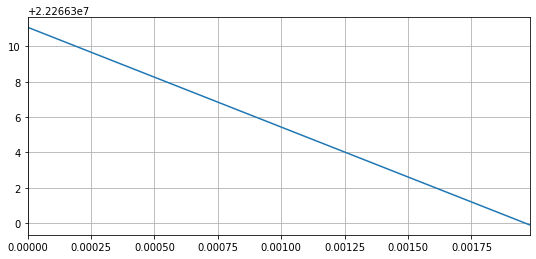

In [18]:
build_plot(X_train, y_train, X_val, y_val)

In [19]:
regr = GradientLR(0.1, iterations=10000, l=0.05)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266028.772680447, R2: 0.6872837124562762


### Задание 5 (2 балла)
Проинтерпретируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Упорядочим признаки по их "вкладу" в конечную стоимость дома, для этого необходимо отсортировать веса
(чем вес признака выше, тем он важнее при оценке стоимости)

In [20]:
header_line = 15
with open("boston.csv", "r") as f:
    for _ in range(header_line - 1):
        f.readline()
    features_names = f.readline()[:-1].split(",")[:-1]
features_names.append("bias")

In [21]:
feature_weights = zip(features_names, regr._w.tolist())
feature_weights = sorted(feature_weights, key=lambda f: f[1], reverse=True)

print("\n".join([f"{f}: {round(w, 2)}" for f, w in feature_weights if f != "bias"]))

rad: 2858.63
rm: 2605.24
zn: 1266.83
b: 797.45
chas: 590.05
age: 295.03
indus: -137.15
crim: -946.28
ptratio: -1965.91
nox: -2005.72
tax: -2453.07
dis: -3285.89
lstat: -4001.36


У некоторых признаков отрицательный вес, это значит что эти признаки занижают цену.